# DES Differential Fault Analysis
Joshua Bernstein, NYU Tandon

This program simulates performing a differential fault analysys on a DES implementation. A fault is injected in the 15th round of the DES algorithm and the changes that result from this fault are exploited to extract the algorithm's secret key. 

# Part 1: Fault Injection Simulation and round key 16 extraction

In a real attack on DES hardware, one or more bits are flipped in right half of the data in the 16th encryption round using physical attack method (eg. laser, power supply variation, etc.). When a fault is injected at this specific point in the encryption process, it is possible to extract the 16th round key using a single equation. This process will be simulated in python below. 


First we need to download the DES implementation and import all necessary libraries. 

In [1]:
# download pydes_faulty.py
!wget -nc "https://raw.githubusercontent.com/Jbernstein721/des/main/pydes_faulty.py"

# import libraries 
import math
import numpy as np
import scipy
import random
import csv
import random
import string
from itertools import chain
import numpy as numpy
from pydes_faulty import des

--2023-03-17 23:15:26--  https://raw.githubusercontent.com/Jbernstein721/des/main/pydes_faulty.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10103 (9.9K) [text/plain]
Saving to: ‘pydes_faulty.py’

pydes_faulty.py     100%[===================>]   9.87K  --.-KB/s    in 0.001s  

2023-03-17 23:15:26 (13.2 MB/s) - ‘pydes_faulty.py’ saved [10103/10103]



Next we need to define tables that are used in the DES process for later use, as well as define several functions to be used in the fault attack. Each function and table is labled with comments describing their purpose. 

In [2]:
######################################### tables ########################################

# inverse initial permuatation
IP= [58, 50, 42, 34, 26, 18, 10, 2,
      60, 52, 44, 36, 28, 20, 12, 4,
      62, 54, 46, 38, 30, 22, 14, 6,
      64, 56, 48, 40, 32, 24, 16, 8,
      57, 49, 41, 33, 25, 17, 9, 1,
      59, 51, 43, 35, 27, 19, 11, 3,
      61, 53, 45, 37, 29, 21, 13, 5,
      63, 55, 47, 39, 31, 23, 15, 7
]

# S boxes
S = [

    [[14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7],
     [0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8],
     [4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0],
     [15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13],
     ],

    [[15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10],
     [3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5],
     [0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15],
     [13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9],
     ],

    [[10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8],
     [13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1],
     [13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7],
     [1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12],
     ],

    [[7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15],
     [13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9],
     [10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4],
     [3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14],
     ],

    [[2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9],
     [14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6],
     [4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14],
     [11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3],
     ],

    [[12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11],
     [10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8],
     [9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6],
     [4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13],
     ],

    [[4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1],
     [13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6],
     [1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2],
     [6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12],
     ],

    [[13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7],
     [1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2],
     [7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8],
     [2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11],
     ]
]

# shifts
shift = [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1]

# expansion function
E =  [
        31,  0,  1,  2,  3,  4,
        3,  4,  5,  6,  7,  8,
        7,  8,  9, 10, 11, 12,
        11, 12, 13, 14, 15, 16,
        15, 16, 17, 18, 19, 20,
        19, 20, 21, 22, 23, 24,
        23, 24, 25, 26, 27, 28,
        27, 28, 29, 30, 31,  0
]

# key permutation 1
PC1 = [
        56, 48, 40, 32, 24, 16,  8,
        0, 57, 49, 41, 33, 25, 17,
        9,  1, 58, 50, 42, 34, 26,
        18, 10,  2, 59, 51, 43, 35,
        62, 54, 46, 38, 30, 22, 14,
        6, 61, 53, 45, 37, 29, 21,
        13,  5, 60, 52, 44, 36, 28,
        20, 12,  4, 27, 19, 11,  3
]

# key permutation 2
PC2 = [
        13, 16, 10, 23, 0, 4,
        2, 27, 14, 5, 20, 9,
        22, 18, 11, 3, 25, 7,
        15, 6, 26, 19, 12, 1,
        40, 51, 30, 36, 46, 54,
        29, 39, 50, 44, 32, 47,
        43, 48, 38, 55, 33, 52,
        45, 41, 49, 35, 28, 31
]

# inverse permutation to unscramble R16
P_inv = [
        9,  17, 23, 31,
        13, 28, 2,  18,
        24, 16, 30, 6,
        26, 20, 10, 1,
        8,  14, 25, 3,
        4,  29, 11, 19,
        32, 12, 22, 7,
        5,  27, 15, 21
]

# converts binary list to integer
def binary_to_int(in_bin):
    # Convert the binary list to a string
    binary_string = ''.join([str(bit) for bit in in_bin])
    # Convert the binary string to an integer
    decimal = int(binary_string, 2)

    return decimal

# convert integer to binary list
def int_to_binary(in_dec, num_bits):


    # Convert the decimal number to a binary string with 4 or 6 bits
    if num_bits == 4:
        binary = format(in_dec, '04b')
    else:
        binary = format(in_dec, '08b')

    # Convert the binary string to a list of integers
    binary_list = [int(bit) for bit in binary]

    return binary_list

# function to generate random plaintext
def generate_plaintext():
    return ''.join(random.choices(string.ascii_uppercase + string.ascii_lowercase + string.digits + string.punctuation, k=8))

# function to separate into left and right halves
def separate(binary_string):
    right = binary_string[:32]
    left = binary_string[32:]
    return left, right

# array flatten funciton
def flatten(lst):
    return [item for sublist in lst for item in sublist]

# function to undo inverse initial permutation
def undo_final_permutation(ciphertext):
    # Convert the ciphertext from binary string to a list of bits
    ciphertext_bits = [int(bit) for bit in ciphertext]

    # Apply the inverse final permutation to the ciphertext
    plaintext_bits = [0] * len(ciphertext_bits)
    for i, position in enumerate(IP):
        plaintext_bits[i] = ciphertext_bits[position]

    # Convert the plaintext from a list of bits to a binary string
    plaintext = ''.join([str(bit) for bit in plaintext_bits])

    return plaintext_bits

# expansion function
def expand(input):
    expanded = []
    for i in E:
        expanded.append(input[i])
    return expanded


def permut(block, table):  # Permut the given block using the given table (so generic method)
    return [block[x - 1] for x in table]


# function to perform bitwise or
def bitwise_xor(in1, in2):
    result = []

    if len(in1) != len(in2):
        print("xor input length error")
        print("in 1 has length", len(in1))
        print("in 2 has length", len(in2))
        raise ValueError("")

    # Compute the bitwise XOR of the two lists of bits
    else:
        for i in range(len(in1)):
            result.append(in1[i] ^ in2[i])
        return result

# function to add parity bits
def add_parity_bits(key):
    # split int 1 byte chunks
    key_8 = []
    key_8 = [key[i:i + 8] for i in range(0, len(key), 8)]

    # count 1s in each byte
    for i in range(8):
        # if number of 1s is odd parity bit = 0, else it is 1
        temp = key_8[i]
        temp7 = key_8[0:7]
        num_1 = temp7.count(1)

        if (temp7.count(1)%2) != 0:
            temp[7] = 0
        else:
            temp[7] = 1
        key_8[i] = temp

    key = flatten(key_8)
    return key

# function to convert binary key to ascii string
def binary_to_ascii(binary_list):
    # Convert the binary list to a string of 0s and 1s
    binary_string = ''.join(str(bit) for bit in binary_list)

    # Convert the binary string to an ASCII string
    ascii_string = ''
    for i in range(0, len(binary_string), 8):
        byte = binary_string[i:i+8]
        ascii_char = chr(int(byte, 2))
        ascii_string += ascii_char

    return ascii_string

def ascii_to_binary(ascii_string):
    # Convert the ASCII string to a binary string
    binary_string = ''
    for char in ascii_string:
        binary_char = bin(ord(char))[2:].zfill(8)
        binary_string += binary_char

    # Convert the binary string to a list of 0s and 1s
    binary_list = [int(bit) for bit in binary_string]

    return binary_list


Now that we have our functions ready, we can choose a key and begin the attack. 

The first line in the following code allows a key to be selected. It must be in ASCII format, with a length of 8 characters. 

Since every 8th bit is a parity bit, a key should be chosen with correct parity bits. The parity bit scheme for a DES key is as follows: for each byte in the key, the number of 1s in the first seven bits of the key should be counted. If there is an even number of 1s, the parity bit should be a 1. If there is an odd number 1s, the parity bit should be 0. 

If the parity bit scheme is ignored the key extraction will still work and a functional key will still be found, however the parity bits may not match the original key for some bytes as the correct parity bits are calculated in the extraction. This will cause some of the characters to be off by 1, but the key will still work since the parity bits are immediately discarded in the DES algorithm 

In [3]:
######################################### declarations/initializations ########################################
# key -- make sure to choose correct parity bits
key = "AEIM!QU}"


# flag to check if there is only one possible key for each s box
done_flag = 0

# bit will be set to 1 if there is only 1 possibility for that s box
done_checks = [0,0,0,0,0,0,0,0]

# array to hold round key 16
key_16 = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],
          [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]

# create instance of des
d = des()

# array of all possible 6 bit values for S-boxes
all_possibilites = []
for i in range(2 ** 6):
    binary_str = bin(i)[2:].zfill(6)
    all_possibilites.append([int(bit) for bit in binary_str])

# array to hold possibilities
possibilities = [all_possibilites,all_possibilites,all_possibilites,all_possibilites,
                 all_possibilites,all_possibilites,all_possibilites,all_possibilites]


Now that we have performed initializations and have selected a key, we can begin the fault attack.

In order to find the correct key, we can exploit the fact that the data is split into eight 6-bit chunks that are used for the substitution box (s-box) addresses in the F function. This allows us to easily test all 2^6 combinations for each s-box. The F function and s-box structure is shown below. (image from: https://en.wikipedia.org/wiki/Data_Encryption_Standard#The_Feistel_(F)_function)

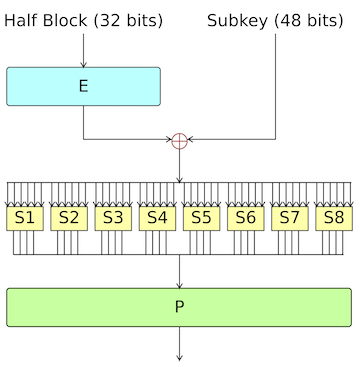

Additionally, due to the fault injection location and the structure of the DES algorithm, only a single equation is required to extract the 16th round key. A block diagram of the DES enryption process is shown below. (image from: https://www.researchgate.net/figure/A-Flowchart-of-DES-Algorithm-31_fig5_339999643) 

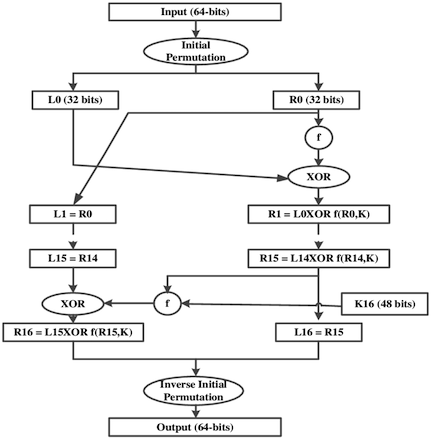

Since the fault is injected into the right half of the data in round 15 (R15), the fault is passed to the F function and propagates through the s-boxes. The s-boxes operate as a lookup table, with a 6-bit input acting as an address to a corresponding 4-bit output. All other logic is combinational, so we can use the fault to determine the 16th round key.

To exploit the fault we perform two separate DES passes, one with no fault which generates a correct ciphertext, and one with a fault which will generate an incorrect ciphertext. We can then compare these results using the below equation to determine key 16 as all values are known except for K16. 




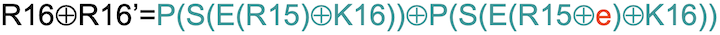






The left half of the equation is simply the XOR of the correct and faulty R16 values, which will result in all 0s except for the bits that were affected by the fault. In the right half of the equation, we must perform some of the DES steps before performing the XOR of the faulty and correct L16 values. (R15 and L16 have the same value, which can be seen in the above DES flow chart.) The F function is essentially performed here, with the data being expanded and XOR with the key value before being passed to the s-boxes. 

To prevent having to brute force all 48 bits of the key, we brute force each s-box one at a time. This is done by testing all possible 6 bit key values in the above equation and saving the ones that satisfy the equation for that particular s-box. We can then pass the new set of possible values through the same process and repeat until there is only one possible key 16 that satisfies the equation.

The code below performs the described process using the following steps:

1) generate correct and faulty ciphertexts 
2) reverse final permuation and split into left and right halves
3) XOR the two right halves and reverse permutation (this can be done to simplify the process rather than permuting the left halves for each loop iteration as all operations are bitwise)
4) Expand both left halves
5) XOR each left half in 6 bit chunks with all possible corresponding key values
6) Pass each resulting chunk through corresponding s-box and save result 
7) Test each s-box result to see if it satisfies the equation and save the ones that do 
8) repeat the loop with the new set of possibilites until there is only one possibility for each s-box remaining
9) Concatenate all results to create round key 16

These steps are also shown in the below flow chart.

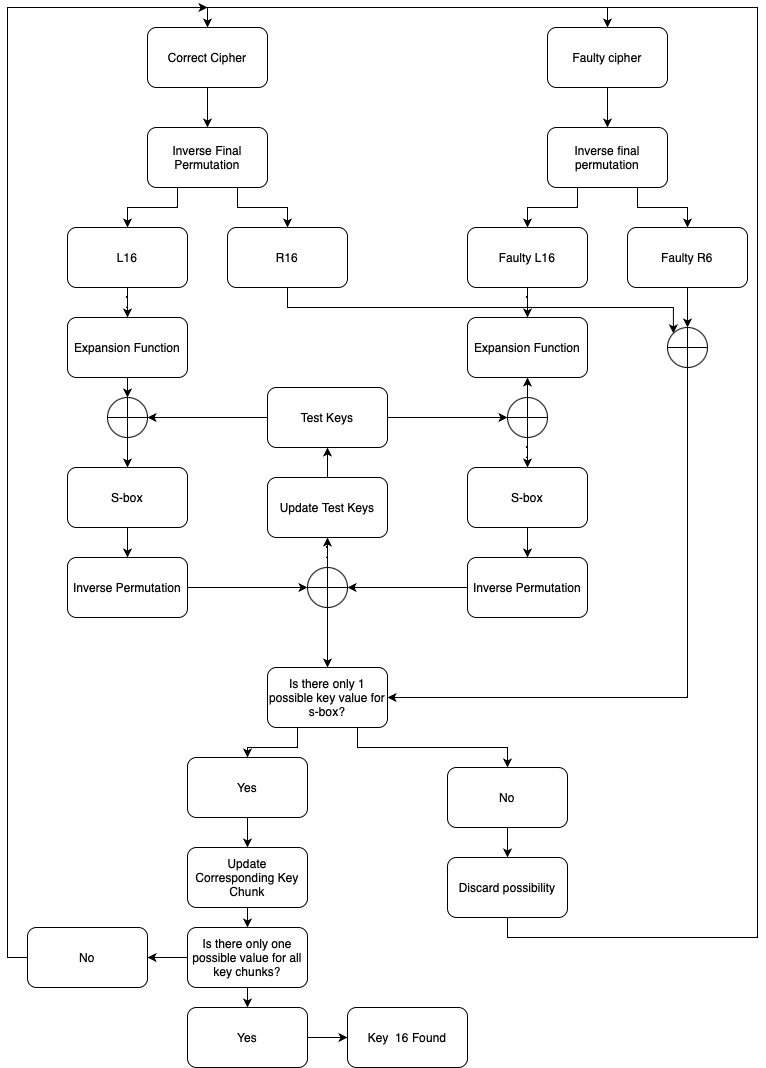

Now that we have discussed how the key 16 recovery process works, we will perform it in the code below.

Note: If you want to run this section again after initial run, you must restart the kernel or there errors will occur due to leftover variable information from pevious run. 

In [4]:
######################################### begin fault attack ########################################

while done_flag != 1:


    # generate random fault bit and random plaintext
    fault_bit = random.randint(0, 31)
    text = generate_plaintext()

    # correct encryption
    ciphered, bin, key_16_real = d.encrypt(key, text, fault=False,roundNum = 16, bitNum = fault_bit)

    # encryption with fault injected in round 15
    cipheredFault, binFault, trash = d.encrypt(key, text, fault=True, roundNum=15, bitNum=fault_bit)

    # undo final permutation on correct and faulty ciphertext
    output = permut(bin, IP)
    outputFault = permut(binFault, IP)

    # separate correct and faulty outputs of final round into left and right halves
    L16, R16 = separate(output)
    L16_f, R16_f = separate(outputFault)

    # xor correct and faulty right halves of round 16 output
    xor_R = bitwise_xor(R16, R16_f)

    # undo permutation of right halves
    xor_R = permut(xor_R,P_inv)

    # split into 4 bit chunks for later comparison
    xor_R_4 = [xor_R[i:i + 4] for i in range(0, len(xor_R), 4)]

    # expand L16 and L16_f (which is the same as R15)
    L16_exp = expand(L16)
    L16_f_exp = expand(L16_f)

    # separate into 6 bit chunks
    L16_exp_6 = [L16_exp[i:i + 6] for i in range(0, len(L16_exp), 6)]
    L16_f_exp_6 = [L16_f_exp[i:i + 6] for i in range(0, len(L16_f_exp), 6)]


    # arrays to hold intermediate values
    xor_L = [[],[],[],[],[],[],[],[]]
    xor_LF = [[],[],[],[],[],[],[],[]]
    xor_L_temp = []
    xor_LF_temp = []

    # perform xor of left half with all possible keys for each s box for correct and faulty cipher
    for i in range(8):
        for j in range(len(possibilities[i])):
            xor_L[i].append(bitwise_xor(L16_exp_6[i],possibilities[i][j]))
            xor_LF[i].append(bitwise_xor(L16_f_exp_6[i], possibilities[i][j]))


######################################### s box process ########################################
    #holds row and column address for s boxes, both correct and faulty
    row_addr_b = []
    row_addr_bf = []
    col_addr_b = []
    col_addr_bf = []

    # sbox outputs for correct and faulty cipher
    sbox_out = [[],[],[],[],[],[],[],[]]
    sbox_out_f= [[],[],[],[],[],[],[],[]]

    for i in range(8):
        for j in range(len(possibilities[i])):

            # get 6 bits from xor of L16 and possible key 16
            temp = xor_L[i][j]
            temp_f = xor_LF[i][j]

            # convert into s box address
            row_addr_b = binary_to_int([temp[0], temp[5]])
            col_addr_b = binary_to_int(temp[1:5])

            # do the same for faulty
            row_addr_bf = binary_to_int([temp_f[0], temp_f[5]])
            col_addr_bf = binary_to_int(temp_f[1:5])

            # get s box output bits
            sbox_out[i].append(int_to_binary(S[i][row_addr_b][col_addr_b],4))

            # do the same for faulty
            sbox_out_f[i].append(int_to_binary(S[i][row_addr_bf][col_addr_bf],4))

######################################### finish equation  ########################################


    current_possibilities = [[],[],[],[],[],[],[],[]]

    # complete right half of equation
    for i in range(8):
        if done_checks[i] != 1:
            for j in range(len(possibilities[i])):

                # xor current correct sbox output with corresponding faulty sbox output
                L_final = bitwise_xor(sbox_out[i][j],sbox_out_f[i][j])

                # check each calculated chunk to see if it fulfils equation. save it if it does
                if L_final == xor_R_4[i]:
                    current_possibilities[i].append(possibilities[i][j])

    # update list of possibilites. if there is no chunk that satisfies equation for an sbox, dont do anything
    for i in range(8):
        if len(current_possibilities[i]) > 0:
            possibilities[i] = current_possibilities[i]

    # if there is only one possibility for the correct chunk, update flag, store in key_16
    for i in range(8):
        if len(possibilities[i]) == 1:
            key_16[i] = flatten(possibilities[i])
            done_checks[i] = 1

    # if all key chunks have been found, exit the loop
    if done_checks == [1,1,1,1,1,1,1,1]:
        done_flag = 1

# flatten recovered key
key_16 = flatten(key_16)

# print original key 16 directly from DES algorithm and recovered key 16
print("Original Round Key 16: ", key_16_real)
print("Recovered Round Key 16:", key_16)

Original Round Key 16:  [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Recovered Round Key 16: [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


# Part 2: Recovering Secret Key from Round 16 Key

We can now use the recovered key 16 to find the oringinal secret key. The key generation process is purely combinational, though there is some information loss so more brute force key testing will be required. 

The key generation process starts with a 64-bit secret key. 8 bits are for parity, and they are discarded in the first step of the algortithm which is a permutation called PC1. After PC1, the resulting 56 bits are split into left and right halves of 28 bits each. For each round, the two halves are left shifted by one or two bits, depending on the round. Finally the two halves are concatenated and passed through a second permutation, PC2, which discards another 8 bits and results in a 48 bit round key. This process is illustrated in the below figure. (image taken from https://en.wikipedia.org/wiki/Data_Encryption_Standard#The_Feistel_(F)_function)

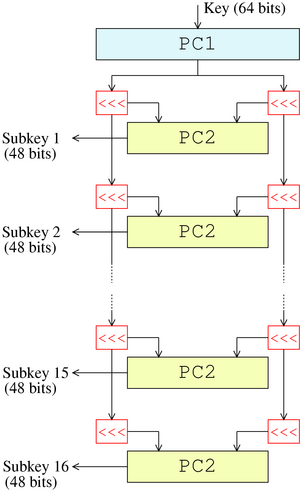

Since PC2 is a lossy process (56 bit input, 48 bit output) we must brute force the final 8 bits. Otherwise, the process is simple combinational logic. Additionally, since there are 28 bits in each half of the round keys and 28 total shifts per side, we do not need to undo any of the left shifts. 

We can recover the secret key using the following steps:

1) Generate a correct ciphertext using a known plaintext
2) Reverse PC2
3) Reverse PC1
4) Insert test bits into known lost bit positions from PC2
5) Calculate parity bits
6) Use generated key to create a test ciphertext
7) If the correct ciphertext and test ciphertext match, the key has been found.

This process is executed in the code below, and the original and recovered keys are printed. 

Note: If original key had incorrect parity bits, each byte of the key may be off by 1 as the algorithm below calculates correct parity bits. The key will still work even if the party bits do not match as the parity bits are discarded in the round key generation process. 

In [5]:
######################################### brute force original key from K16  ########################################

# undo PC2, insert 99 for unknown bits
pc2_key = [99] * 56
for i in range(len(key_16)):
    pc2_key[PC2[i]] = key_16[i]

# undo PC1, insert 0 for parity bit placeholders
pc1_key = [0] * 64
for i in range(len(pc2_key)):
    pc1_key[PC1[i]] = pc2_key[i]

# create lits of all possible 8 bit binary numbers
bits_8 = []
for i in range(256):
    bits_8.append(int_to_binary(i,8))

# test text to check keys
text = "12345678"

# bits that must be brute forced
missing_bits = [13,14,18,19,50,53,57,59]

# brute force remaining 8 bits
for i in range(256):

    test_key_np = [0]*64
    current_bits = bits_8[i]

    # replace missing bits with current test bits
    for j in range(8):
        pc1_key[missing_bits[j]] = current_bits[j]

    # convert to ascii
    test_key_ascii = binary_to_ascii(pc1_key)

    # test current potential key by doing reglar encryption and an encryption using test key
    cipher_real, bin_real, key_16_real = d.encrypt(key,text)
    cipher_test, bin_test, trash       = d.encrypt(test_key_ascii,text)

    # if both ciphertexts are the same, key has key has been found
    if cipher_test == cipher_real:
        recovered_key = pc1_key
        break

    if i == 255:
        print("Error: no key found")

# print original key and recovered key
recovered_key = add_parity_bits(recovered_key)
recovered_key_ascii = binary_to_ascii(recovered_key)

print("Original Key:", key)
print("Recovered Key:", recovered_key_ascii)


Original Key: AEIM!QU}
Recovered Key: AEIM!QU}
